## Experimentation and Uplift Testing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import datetime

from scipy.stats import ttest_ind

from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics 

from scipy.spatial.distance import cdist

%matplotlib inline 

In [2]:
QVI = pd.read_csv(r'QVI_data.csv')

In [3]:
QVI.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [4]:
QVI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
LYLTY_CARD_NBR      264834 non-null int64
DATE                264834 non-null object
STORE_NBR           264834 non-null int64
TXN_ID              264834 non-null int64
PROD_NBR            264834 non-null int64
PROD_NAME           264834 non-null object
PROD_QTY            264834 non-null int64
TOT_SALES           264834 non-null float64
PACK_SIZE           264834 non-null int64
BRAND               264834 non-null object
LIFESTAGE           264834 non-null object
PREMIUM_CUSTOMER    264834 non-null object
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


**Select control stores:**<br>
The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established
stores that are operational for the entire observation period.
We would want to match trial stores to control stores that are similar to the trial store prior to the trial period
of Feb 2019 in terms of :
<ol>
<ol>• Monthly overall sales revenue</ol>
<ol>• Monthly number of customers</ol>
<ol>• Monthly number of transactions per customer</ol>
</ol>


In [5]:
# Converting to datetime object:
QVI.DATE = pd.to_datetime(QVI.DATE)
#Creating month column:
QVI['Month_Date'] = QVI['DATE'].dt.to_period('M')

In [6]:
QVI['STORE_NBR'].nunique()

272

In [7]:
QVI['Month_Date'].min()

Period('2018-07', 'M')

In [8]:
pre_trial_date = QVI[QVI['Month_Date'] <'2019-03']['Month_Date'].sort_values().unique()
pre_trial_date

<PeriodArray>
['2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01',
 '2019-02']
Length: 8, dtype: period[M]

In [9]:
QVI_pre_Trial = QVI[QVI['Month_Date'].isin(pre_trial_date)]

In [10]:
stores = QVI_pre_Trial['STORE_NBR'].unique()

In [11]:
def store_throughout_pretrail(stores):
    stores_trial = []
    for stor in stores:
        stor_date = pd.PeriodIndex(QVI_pre_Trial['Month_Date'][QVI_pre_Trial['STORE_NBR'] == stor].unique()).sort_values()
        if np.array_equal(stor_date, pre_trial_date):
            stores_trial.append(stor)
    return stores_trial

In [12]:
stores_trial = store_throughout_pretrail(stores)

In [13]:
len(stores_trial)

260

In [14]:
#Stores with data throughout pre-trail date:
QVI_pre_Trial = QVI_pre_Trial[QVI_pre_Trial['STORE_NBR'].isin(stores)]

In [15]:
monthly = QVI_pre_Trial.groupby(['STORE_NBR'])['PROD_QTY', 'TOT_SALES'].sum().reset_index()
monthly['Price/Unit'] = np.round((monthly['TOT_SALES']/monthly['PROD_QTY']),3)
monthly['Customers'] = QVI_pre_Trial.groupby(['STORE_NBR'])['LYLTY_CARD_NBR'].nunique().reset_index()['LYLTY_CARD_NBR']
monthly['Transactions'] = QVI_pre_Trial.groupby(['STORE_NBR'])['TXN_ID'].nunique().reset_index()['TXN_ID']
monthly['TxnPerCust'] = np.round((monthly['Transactions']/monthly['Customers']), 3)
monthly['ChipsPerTxn'] = np.round((monthly['PROD_QTY']/monthly['Transactions']),3)
monthly.drop(['Transactions','PROD_QTY','Price/Unit','ChipsPerTxn'], axis = 1, inplace=True)
# monthly.set_index('STORE_NBR', inplace=True)

In [16]:
monthly.head(7)

,STORE_NBR,TOT_SALES,Customers,TxnPerCust
0,1,1612.30,267,1.449
1,2,1267.90,239,1.331
2,3,8723.85,347,2.908
3,4,10010.40,357,3.182
4,5,6466.70,233,3.961
5,6,1842.80,262,1.370
6,7,8339.90,354,2.757


In [17]:
#Elbow Method to determine the number of clusters:
K = range(1,20)
distortion = []
inertias = []
mappings1 = {}
mappings2 = {}
for k in K:
    kmod = KMeans(n_clusters = k)
    kmod.fit(monthly)
    distortion.append(sum(np.min(cdist(monthly, kmod.cluster_centers_, 
                      'euclidean'),axis=1))/monthly.shape[0])
    inertias.append(kmod.inertia_)
    mappings1[k] = sum(np.min(cdist(monthly, kmod.cluster_centers_, 
                      'euclidean'),axis=1))/monthly.shape[0]
    mappings2[k] = kmod.inertia_

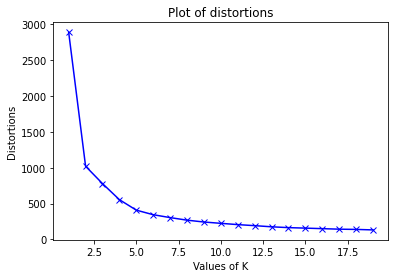

In [18]:
plt.plot(K, distortion, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortions')
plt.title("Plot of distortions")
plt.show()

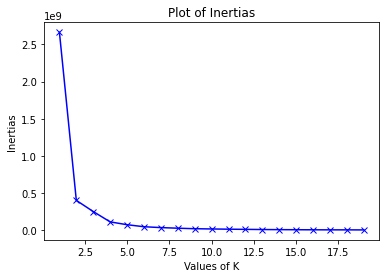

In [19]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title("Plot of Inertias")
plt.show()

We can conclude that 5 clusters are appropriate.

In [20]:
km = KMeans(n_clusters=5)
monthly['Cluster'] = km.fit_predict(monthly[['TOT_SALES','Customers','TxnPerCust']])

In [21]:
reduced_data = PCA(n_components = 2).fit_transform(monthly[['TOT_SALES','Customers','TxnPerCust']])
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

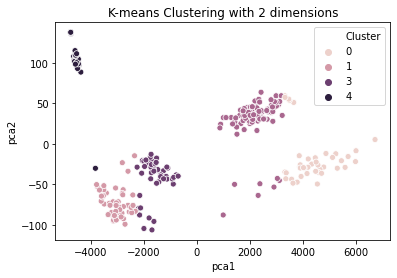

In [22]:
sns.scatterplot(x="pca1", y="pca2", hue=monthly['Cluster'], data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

In [23]:
monthly[monthly['STORE_NBR']==77]

,STORE_NBR,TOT_SALES,Customers,TxnPerCust,Cluster
76,77,1934.0,264,1.367,1


In [24]:
#Lets keep the clusters with our trial stores and discard the rest clusters:

In [25]:
Cluster77 = monthly[monthly['Cluster']==0]
Cluster86 = monthly[monthly['Cluster']==2]
Cluster88 = monthly[monthly['Cluster']==1]

In [27]:
# Cluster77.loc[41]

### Lets compare the top 4 stores and select the closest as the control store for each of the trial stores 77, 86 and 88.

In [28]:
Cluster77 = Cluster77.reset_index().drop('index', axis = 1)
eu_dist_cluster77 = pd.DataFrame(euclidean_distances(pd.DataFrame(Cluster77[['TOT_SALES','Customers','TxnPerCust']].values.flatten())))
eu_dist_cluster77.iloc[45].sort_values().head()

45     0.00
63    38.15
81    59.25
90    77.60
57    98.50
Name: 45, dtype: float64

In [29]:
Cluster77[Cluster77['STORE_NBR']==77]

,STORE_NBR,TOT_SALES,Customers,TxnPerCust,Cluster


In [30]:
Cluster77[Cluster77['STORE_NBR']==233]

,STORE_NBR,TOT_SALES,Customers,TxnPerCust,Cluster


**After comparison we have chose store 233 as the control store for 77**

In [31]:
Cluster86 = Cluster86.reset_index().drop('index', axis =1)
eu_dist_cluster86 = pd.DataFrame(euclidean_distances(pd.DataFrame(Cluster86[['TOT_SALES','Customers','TxnPerCust']].values.flatten())))
eu_dist_cluster86.loc[78].sort_values().head()

78      0.00
24      0.45
183     1.25
177    10.15
87     12.90
Name: 78, dtype: float64

In [32]:
Cluster86[Cluster86['STORE_NBR']==86]

,STORE_NBR,TOT_SALES,Customers,TxnPerCust,Cluster
26,86,7033.05,267,3.798,2


In [33]:
Cluster86[Cluster86['STORE_NBR']==155]

,STORE_NBR,TOT_SALES,Customers,TxnPerCust,Cluster
55,155,7199.9,246,4.163,2


**After comparison we have chose store 155 as the control store for 86**

In [34]:
Cluster88 = Cluster88.reset_index().drop('index', axis = 1)
eu_dist_cluster88 = pd.DataFrame(euclidean_distances(pd.DataFrame(Cluster88[['TOT_SALES','Customers','TxnPerCust']].values.flatten())))
eu_dist_cluster88.iloc[48].sort_values().head()

48     0.0
15     5.2
90    52.2
63    60.0
0     74.9
Name: 48, dtype: float64

In [35]:
Cluster88[Cluster88['STORE_NBR']==88]

,STORE_NBR,TOT_SALES,Customers,TxnPerCust,Cluster


In [36]:
Cluster88[Cluster88['STORE_NBR']==237]

,STORE_NBR,TOT_SALES,Customers,TxnPerCust,Cluster


**After comparison we have chose store 237 as the control store for 88**

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [37]:
### Lets plot the trend of the sales of these stores to stores over the months:

In [38]:
df0 = QVI[(QVI['Month_Date'] >'2018-06') & (QVI['Month_Date'] <'2019-03') & (~QVI['STORE_NBR'].isin([77, 233, 86, 155, 88, 237]))]
df0_monthly = pd.merge(df0.groupby(['Month_Date'])['PROD_QTY', 'TOT_SALES'].sum().reset_index(), df0.groupby(['Month_Date'])['TXN_ID', 'LYLTY_CARD_NBR'].nunique().reset_index(), on=['Month_Date'])
df0_monthly['STORE_NBR'] = 'Others'
df0_monthly['TOT_SALES'] = round(df0_monthly['TOT_SALES']/df0['STORE_NBR'].nunique(),2)
df0_monthly['LYLTY_CARD_NBR'] = round(df0_monthly['LYLTY_CARD_NBR']/df0['STORE_NBR'].nunique(),2)

In [39]:
df0['STORE_NBR'].nunique()

265

In [40]:
# df0_monthly

In [41]:
df1 = QVI[(QVI['Month_Date'] >'2018-06') & (QVI['Month_Date'] <'2019-03') & (QVI['STORE_NBR'].isin([77, 233, 86, 155, 88, 237]))]
df1_monthly = pd.merge(df1.groupby(['STORE_NBR','Month_Date'])['PROD_QTY', 'TOT_SALES'].sum().reset_index(), df1.groupby(['STORE_NBR','Month_Date'])['TXN_ID', 'LYLTY_CARD_NBR'].nunique().reset_index(), on=['STORE_NBR', 'Month_Date'])

In [42]:
frames = [df0_monthly, df1_monthly]
df_monthly = pd.concat(frames, sort=True).reset_index()
df_monthly = df_monthly.drop('index', axis = 1)
df_monthly['Month_Date'] = df_monthly.Month_Date.astype(str)

In [43]:
df_monthly.head()

,LYLTY_CARD_NBR,Month_Date,PROD_QTY,STORE_NBR,TOT_SALES,TXN_ID
0,68.76,2018-07,41939,Others,604.20,21762
1,68.57,2018-08,40070,Others,578.50,21614
2,66.61,2018-09,40487,Others,586.39,20926
3,68.06,2018-10,41550,Others,601.56,21507
4,67.00,2018-11,40608,Others,585.58,21050


### Plotting total sales for pairs of control and trial (77, 233), (86, 155), (88, 237)

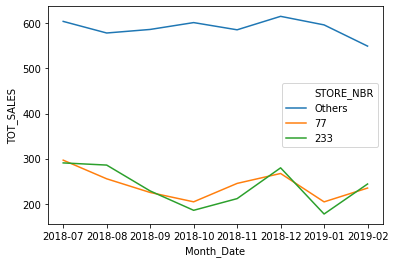

In [44]:
ax = sns.lineplot(x='Month_Date', y='TOT_SALES', hue="STORE_NBR", data = df_monthly.query("STORE_NBR == 77 | STORE_NBR == 233 | STORE_NBR == 'Others'"))
# ax.set_xticklabels(df['Month_Date'])

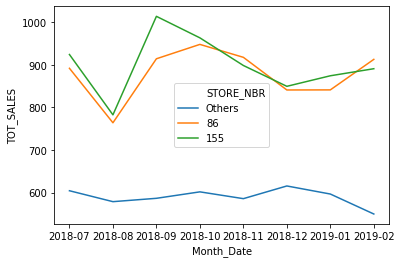

In [45]:
ax = sns.lineplot(x='Month_Date', y='TOT_SALES', hue="STORE_NBR", data = df_monthly.query("STORE_NBR == 86 | STORE_NBR == 155 | STORE_NBR == 'Others'"))

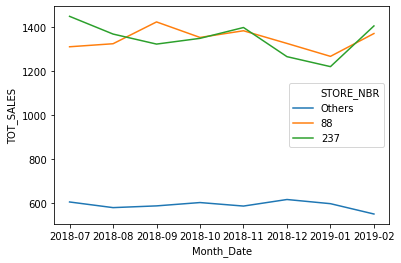

In [46]:
ax = sns.lineplot(x='Month_Date', y='TOT_SALES', hue="STORE_NBR", data = df_monthly.query("STORE_NBR == 88 | STORE_NBR == 237 | STORE_NBR == 'Others'"))

### Plotting total Cutomers for pairs of control and trial (77, 233), (86, 155), (88, 237)

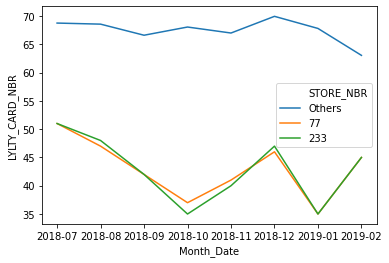

In [47]:
ax = sns.lineplot(x='Month_Date', y='LYLTY_CARD_NBR', hue="STORE_NBR", data = df_monthly.query("STORE_NBR == 77 | STORE_NBR == 233 | STORE_NBR == 'Others'"))

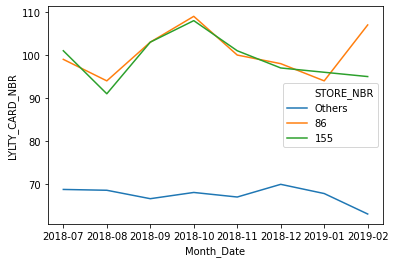

In [48]:
ax = sns.lineplot(x='Month_Date', y='LYLTY_CARD_NBR', hue="STORE_NBR", data = df_monthly.query("STORE_NBR == 86 | STORE_NBR == 155 | STORE_NBR == 'Others'"))

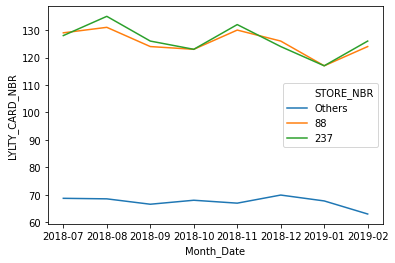

In [49]:
ax = sns.lineplot(x='Month_Date', y='LYLTY_CARD_NBR', hue="STORE_NBR", data = df_monthly.query("STORE_NBR == 88 | STORE_NBR == 237 | STORE_NBR == 'Others'"))

#### From the above trends between each control- Trial store pair in Total Sales and Customers, we can conclude that they are indeed very similar.

### Now let's compare the Sales of the control stores to the test stores during the trial period: Mar 2019 to June 2019

In [50]:
df = pd.merge(QVI.groupby(['STORE_NBR','Month_Date'])['PROD_QTY', 'TOT_SALES'].sum().reset_index(), QVI.groupby(['STORE_NBR','Month_Date'])['TXN_ID', 'LYLTY_CARD_NBR'].nunique().reset_index(), on=['STORE_NBR', 'Month_Date'])
df['TXN/CUSTOMER'] = round(df['TXN_ID']/ df['LYLTY_CARD_NBR'], 3)
df['CHIPS/TXN'] = round(df['PROD_QTY']/ df['TXN_ID'], 3)
### Trial period: March 2019, April 2019, May 2019 and June 2019
df = df[(df['Month_Date'] >'2019-02') & (df['Month_Date'] <'2019-07') & (df['STORE_NBR'].isin([77, 233, 155, 86, 88, 237]))]
df  = df.reset_index().drop('index', axis = 1)
df['Month_Date'] = df.Month_Date.astype(str)
# df['STORE_NBR'] = df.STORE_NBR.astype(str)

In [51]:
df77_trial = df[df['STORE_NBR'].isin(['77','233'])]
df77_trial = df77_trial.reset_index().drop('index', axis = 1)

In [52]:
df86_trial = df[df['STORE_NBR'].isin(['86','155'])]
df86_trial = df86_trial.reset_index().drop('index', axis = 1)

In [53]:
df88_trial = df[df['STORE_NBR'].isin(['88','237'])]
df88_trial = df88_trial.reset_index().drop('index', axis = 1)

In [54]:
df77_trial

,STORE_NBR,Month_Date,PROD_QTY,TOT_SALES,TXN_ID,LYLTY_CARD_NBR,TXN/CUSTOMER,CHIPS/TXN
0,77,2019-03,82,278.5,55,50,1.100,1.491
1,77,2019-04,78,263.5,48,47,1.021,1.625
2,77,2019-05,84,299.3,56,55,1.018,1.500
3,77,2019-06,70,264.7,42,41,1.024,1.667
4,233,2019-03,59,199.1,41,40,1.025,1.439
5,233,2019-04,46,158.6,32,30,1.067,1.438
6,233,2019-05,92,344.4,62,57,1.088,1.484
7,233,2019-06,61,221.0,41,41,1.000,1.488


#### Now we need to compare the trial store to the control store to see there is any change in sales or customers and confirm our hypothesis.

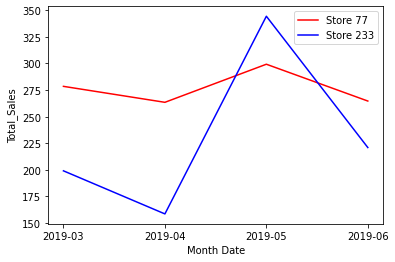

In [55]:
plt.plot(df77_trial['Month_Date'].loc[0:3], df77_trial['TOT_SALES'].loc[0:3], 'r-', label='Store 77')
plt.plot(df77_trial['Month_Date'].loc[4:], df77_trial['TOT_SALES'].loc[4:], 'b-', label='Store 233')
plt.ylabel('Total_Sales')
plt.xlabel('Month Date')
plt.legend();

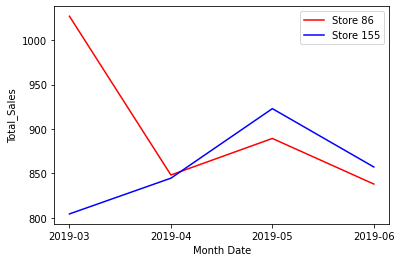

In [56]:
# ax = sns.lineplot(x='Month_Date', y='TOT_SALES', data = df86_trial, hue = 'STORE_NBR')
plt.plot(df86_trial['Month_Date'].loc[0:3], df86_trial['TOT_SALES'].loc[0:3], 'r-', label='Store 86')
plt.plot(df86_trial['Month_Date'].loc[4:], df86_trial['TOT_SALES'].loc[4:], 'b-', label='Store 155')
plt.ylabel('Total_Sales')
plt.xlabel('Month Date')
plt.legend();

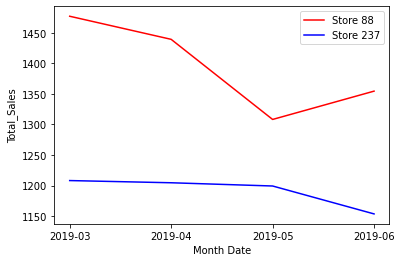

In [57]:
plt.plot(df88_trial['Month_Date'].loc[0:3], df88_trial['TOT_SALES'].loc[0:3], 'r-', label='Store 88')
plt.plot(df88_trial['Month_Date'].loc[4:], df88_trial['TOT_SALES'].loc[4:], 'b-', label='Store 237')
plt.ylabel('Total_Sales')
plt.xlabel('Month Date')
plt.legend();

In [58]:
# Stores_Monthly_Sales = pd.DataFrame(QVI_pre_Trial[QVI_pre_Trial['STORE_NBR'].isin([77, 233, 155, 86, 88, 237])].groupby(['STORE_NBR', 'Month_Date'])['TOT_SALES'].sum()).reset_index()
# scale = round(pd.DataFrame(Stores_Monthly_Sales.groupby('STORE_NBR')['TOT_SALES'].sum().loc[[77, 86, 88]]).reset_index()['TOT_SALES']/pd.DataFrame(Stores_Monthly_Sales.groupby('STORE_NBR')['TOT_SALES'].sum().loc[[233, 155, 237]]).reset_index()['TOT_SALES'], 3)

In [59]:
df77_trial.groupby('STORE_NBR')['TOT_SALES'].sum()

STORE_NBR
77     1106.0
233     923.1
Name: TOT_SALES, dtype: float64

In [60]:
df86_trial.groupby('STORE_NBR')['TOT_SALES'].sum()

STORE_NBR
86     3602.30
155    3429.05
Name: TOT_SALES, dtype: float64

In [61]:
df88_trial.groupby('STORE_NBR')['TOT_SALES'].sum()

STORE_NBR
88     5579.45
237    4765.70
Name: TOT_SALES, dtype: float64

<ol>difference in sales of trial stores in trial period and pre-trial period</ol>
<ol>difference in sales of control stores in trial period and pre-trial period.</ol>

In [62]:
# df77_trial

In [63]:
pretrial = df1[(df1['STORE_NBR'].isin([77, 233, 155, 86, 88, 237]))].groupby(['STORE_NBR','Month_Date'])['PROD_QTY','TOT_SALES'].sum().reset_index()

In [64]:
pretrial['sales_diff'] = pretrial.groupby('STORE_NBR')['TOT_SALES'].diff()

In [65]:
# pretrial

In [66]:
def average_diff(s1, s2):
       growth = round(s1.mean() - s2.mean(), 3)
       return growth

In [67]:
#77 - # 233

In [68]:
average_diff(pretrial.loc[0:7]['TOT_SALES'], pretrial.loc[32:39]['TOT_SALES'])

3.775

In [69]:
meandiff_1 = average_diff(df['TOT_SALES'].loc[0:3], df.loc[16:19]['TOT_SALES'])

Here we can see that during the trial period, sales of our trial store 77 is more than control store 233. But is this result significant enough to say that the experiment is successful?
Lets test this hyposthesis.

**Null Hypothesis: $ H_{0} : μ_{77} - μ_{233} = 0 $** <br>
**Alternate Hypothesis: $ H_{1} :  μ_{77} - μ_{233} = 45.73 $**

**CONDITIONS:**
    <ol>Indepedent Observations:</ol>
    1. Random Assignment
    2. n < 10% of population        
    Sample size/ Skew: Sample size is n >=30 or distribution is normal.

In [70]:
sampled_77 = np.random.choice(df.loc[0:3]['TOT_SALES'], 15)
sampled_77_pre = np.random.choice(pretrial.loc[0:7]['TOT_SALES'], 15)
stat, p = ttest_ind(sampled_77, sampled_77_pre)
stat, p

(3.472664150029071, 0.001692489013806267)

Since p value is less than 5% signifance level, we can reject the null hypothesis that there is no difference between the pre-trial and trial period sales.

In [74]:
sampled_86 = np.random.choice(df.loc[4:7]['TOT_SALES'], 15)
sampled_86_pre = np.random.choice(pretrial.loc[8:15]['TOT_SALES'], 15)
stat, p = ttest_ind(sampled_86, sampled_86_pre)
stat, p

(0.12546120380292838, 0.9010549303016235)

Since P-value is 0.9 > 0.05 , we fail to reject the null.

In [72]:
sampled_88 = np.random.choice(df.loc[8:11]['TOT_SALES'], 15)
sampled_88_pre = np.random.choice(pretrial.loc[16:23]['TOT_SALES'], 15)
stat, p = ttest_ind(sampled_88, sampled_88_pre)
stat, p

(2.7925487414533188, 0.00932088068080456)

For store 88, we see p-value is lesser than 5% so we can reject the null for this.

In [ ]:
# # From the above we can write standard deviations as that :
# size = len(df['TOT_SALES'].loc[0:3])
# degree_of_freedom = size - 1
# s1 = 16.65
# s2 = 80.04
# std_error = math.sqrt(((s1**2)/size) + ((s2**2)/size))
# T = (meandiff_1-0)/std_error

In [ ]:
# sampled_77 = np.random.choice(df['TOT_SALES'].loc[0:3], 15)
# sampled_233 = np.random.choice(df.loc[16:19]['TOT_SALES'], 15)
# stat, p = ttest_ind(sampled_77, sampled_233)
# stat, p
# sampled_86 = np.random.choice(df.loc[4:7]['TOT_SALES'], 15)
# sampled_155 = np.random.choice(df.loc[12:15]['TOT_SALES'], 15)
# stat, p = ttest_ind(sampled_86, sampled_155)
# stat, p
# sampled_88 = np.random.choice(df.loc[8:11]['TOT_SALES'], 15)
# sampled_237 = np.random.choice(df.loc[20:]['TOT_SALES'], 15)
# stat, p = ttest_ind(sampled_86, sampled_155)
# stat, p